# Генеративно-змагальна мережа

## Завдання

Використовуючи бібліотеку **PyTorch**, створіть генератовно-змагальну мережу (GAN) для генерації зображень цифр **MNIST**.

1. Завантажте набір даних MNIST з використанням torchvision.datasets.
2. Створіть генератор, який приймає на вхід випадковий вектор з шумом та генерує зображення цифр MNIST.
3. Створіть дискримінатор, який приймає на вхід зображення цифр MNIST та визначає, чи є це реальне зображення чи згенероване генератором.
4. Обидві моделі повинні мати декілька шарів зі зменшенням розмірності зображення, використовуючи згортувальні та пулінгові шари.
5. Навчіть моделігенерувати нові зображення цифр MNIST, використовуючи взаємодію генератора та дискримінатора з використанням функції втрат GAN (adversarial loss).
6. Після навчання виведіть кілька згенерованих зображень та порівняйте їх з оригінальними зображеннями з набору даних MNIST.

## Розв'язок

In [9]:
"""
Import necessary libraries to create a generative adversarial network
The code is mainly developed using the PyTorch library
"""
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

import numpy as np
import matplotlib.pyplot as plt

In [10]:
"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
"""
Hyperparameter settings
"""
epochs = 100
lr = 2e-4
batch_size = 64
loss = nn.BCELoss()


In [12]:
"""
Network Architectures
The following are the discriminator and generator architectures
"""

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 1)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return nn.Sigmoid()(x)


class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(128, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 784)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return nn.Tanh()(x)

In [13]:
# Model
G = generator().to(device)
D = discriminator().to(device)

In [14]:
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [15]:
"""
Image transformation and dataloader creation
Note that we are training generation and not classification, and hence
only the train_loader is loaded
"""
# Transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [16]:
# Load data
train_set = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 11557480.00it/s]


Extracting mnist/MNIST\raw\train-images-idx3-ubyte.gz to mnist/MNIST\raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 14587631.72it/s]


Extracting mnist/MNIST\raw\train-labels-idx1-ubyte.gz to mnist/MNIST\raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 6639361.97it/s]


Extracting mnist/MNIST\raw\t10k-images-idx3-ubyte.gz to mnist/MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 2273875.48it/s]


Extracting mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist/MNIST\raw



In [17]:
"""
Network training procedure
Every step both the loss for disciminator and generator is updated
Discriminator aims to classify reals and fakes
Generator aims to generate images as realistic as possible
"""
for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(train_loader):
        idx += 1

        # Training the discriminator
        # Real inputs are actual images of the MNIST dataset
        # Fake inputs are from the generator
        # Real inputs should be classified as 1 and fake as 0
        real_inputs = imgs.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Training the generator
        # For generator, goal is to make the discriminator believe everything is 1
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))

    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')

Epoch 0 Iteration 100: discriminator_loss 0.669 generator_loss 0.926
Epoch 0 Iteration 200: discriminator_loss 0.713 generator_loss 0.710
Epoch 0 Iteration 300: discriminator_loss 0.652 generator_loss 0.719
Epoch 0 Iteration 400: discriminator_loss 0.595 generator_loss 0.823
Epoch 0 Iteration 500: discriminator_loss 0.595 generator_loss 0.791
Epoch 0 Iteration 600: discriminator_loss 0.562 generator_loss 0.812
Epoch 0 Iteration 700: discriminator_loss 0.490 generator_loss 0.905
Epoch 0 Iteration 800: discriminator_loss 0.529 generator_loss 0.930
Epoch 0 Iteration 900: discriminator_loss 0.557 generator_loss 0.931
Epoch 0 Iteration 938: discriminator_loss 0.492 generator_loss 1.152
Epoch 1 Iteration 100: discriminator_loss 0.408 generator_loss 1.202
Epoch 1 Iteration 200: discriminator_loss 0.465 generator_loss 1.211
Epoch 1 Iteration 300: discriminator_loss 0.427 generator_loss 1.366
Epoch 1 Iteration 400: discriminator_loss 0.443 generator_loss 1.568
Epoch 1 Iteration 500: discriminat

Epoch 11 Iteration 938: discriminator_loss 0.629 generator_loss 0.640
Epoch 12 Iteration 100: discriminator_loss 0.644 generator_loss 0.746
Epoch 12 Iteration 200: discriminator_loss 0.645 generator_loss 0.784
Epoch 12 Iteration 300: discriminator_loss 0.671 generator_loss 0.989
Epoch 12 Iteration 400: discriminator_loss 0.645 generator_loss 0.693
Epoch 12 Iteration 500: discriminator_loss 0.711 generator_loss 1.110
Epoch 12 Iteration 600: discriminator_loss 0.658 generator_loss 0.785
Epoch 12 Iteration 700: discriminator_loss 0.633 generator_loss 0.902
Epoch 12 Iteration 800: discriminator_loss 0.633 generator_loss 1.143
Epoch 12 Iteration 900: discriminator_loss 0.628 generator_loss 0.865
Epoch 12 Iteration 938: discriminator_loss 0.681 generator_loss 0.920
Epoch 13 Iteration 100: discriminator_loss 0.664 generator_loss 0.989
Epoch 13 Iteration 200: discriminator_loss 0.618 generator_loss 0.907
Epoch 13 Iteration 300: discriminator_loss 0.667 generator_loss 0.755
Epoch 13 Iteration 4

Epoch 23 Iteration 700: discriminator_loss 0.721 generator_loss 0.903
Epoch 23 Iteration 800: discriminator_loss 0.673 generator_loss 0.729
Epoch 23 Iteration 900: discriminator_loss 0.650 generator_loss 0.761
Epoch 23 Iteration 938: discriminator_loss 0.702 generator_loss 1.029
Epoch 24 Iteration 100: discriminator_loss 0.715 generator_loss 0.682
Epoch 24 Iteration 200: discriminator_loss 0.650 generator_loss 0.883
Epoch 24 Iteration 300: discriminator_loss 0.662 generator_loss 0.685
Epoch 24 Iteration 400: discriminator_loss 0.631 generator_loss 0.917
Epoch 24 Iteration 500: discriminator_loss 0.642 generator_loss 0.989
Epoch 24 Iteration 600: discriminator_loss 0.655 generator_loss 0.803
Epoch 24 Iteration 700: discriminator_loss 0.673 generator_loss 0.754
Epoch 24 Iteration 800: discriminator_loss 0.661 generator_loss 0.967
Epoch 24 Iteration 900: discriminator_loss 0.639 generator_loss 0.650
Epoch 24 Iteration 938: discriminator_loss 0.682 generator_loss 0.642
Epoch 25 Iteration 1

Epoch 35 Iteration 400: discriminator_loss 0.688 generator_loss 0.564
Epoch 35 Iteration 500: discriminator_loss 0.698 generator_loss 0.681
Epoch 35 Iteration 600: discriminator_loss 0.677 generator_loss 0.836
Epoch 35 Iteration 700: discriminator_loss 0.683 generator_loss 0.744
Epoch 35 Iteration 800: discriminator_loss 0.683 generator_loss 0.682
Epoch 35 Iteration 900: discriminator_loss 0.626 generator_loss 0.839
Epoch 35 Iteration 938: discriminator_loss 0.680 generator_loss 0.919
Epoch 36 Iteration 100: discriminator_loss 0.664 generator_loss 0.875
Epoch 36 Iteration 200: discriminator_loss 0.670 generator_loss 0.616
Epoch 36 Iteration 300: discriminator_loss 0.698 generator_loss 0.805
Epoch 36 Iteration 400: discriminator_loss 0.643 generator_loss 0.598
Epoch 36 Iteration 500: discriminator_loss 0.685 generator_loss 0.710
Epoch 36 Iteration 600: discriminator_loss 0.682 generator_loss 0.784
Epoch 36 Iteration 700: discriminator_loss 0.660 generator_loss 0.748
Epoch 36 Iteration 8

Epoch 47 Iteration 100: discriminator_loss 0.696 generator_loss 0.760
Epoch 47 Iteration 200: discriminator_loss 0.698 generator_loss 0.899
Epoch 47 Iteration 300: discriminator_loss 0.677 generator_loss 0.916
Epoch 47 Iteration 400: discriminator_loss 0.669 generator_loss 0.839
Epoch 47 Iteration 500: discriminator_loss 0.657 generator_loss 0.794
Epoch 47 Iteration 600: discriminator_loss 0.659 generator_loss 0.715
Epoch 47 Iteration 700: discriminator_loss 0.655 generator_loss 0.856
Epoch 47 Iteration 800: discriminator_loss 0.694 generator_loss 0.571
Epoch 47 Iteration 900: discriminator_loss 0.665 generator_loss 0.702
Epoch 47 Iteration 938: discriminator_loss 0.684 generator_loss 0.742
Epoch 48 Iteration 100: discriminator_loss 0.664 generator_loss 0.735
Epoch 48 Iteration 200: discriminator_loss 0.663 generator_loss 0.882
Epoch 48 Iteration 300: discriminator_loss 0.706 generator_loss 0.784
Epoch 48 Iteration 400: discriminator_loss 0.657 generator_loss 0.804
Epoch 48 Iteration 5

Epoch 58 Iteration 800: discriminator_loss 0.671 generator_loss 0.937
Epoch 58 Iteration 900: discriminator_loss 0.669 generator_loss 0.938
Epoch 58 Iteration 938: discriminator_loss 0.647 generator_loss 0.726
Epoch 59 Iteration 100: discriminator_loss 0.715 generator_loss 0.764
Epoch 59 Iteration 200: discriminator_loss 0.643 generator_loss 0.828
Epoch 59 Iteration 300: discriminator_loss 0.654 generator_loss 0.713
Epoch 59 Iteration 400: discriminator_loss 0.706 generator_loss 0.795
Epoch 59 Iteration 500: discriminator_loss 0.669 generator_loss 0.986
Epoch 59 Iteration 600: discriminator_loss 0.693 generator_loss 0.909
Epoch 59 Iteration 700: discriminator_loss 0.702 generator_loss 0.568
Epoch 59 Iteration 800: discriminator_loss 0.681 generator_loss 0.835
Epoch 59 Iteration 900: discriminator_loss 0.679 generator_loss 0.616
Epoch 59 Iteration 938: discriminator_loss 0.704 generator_loss 0.703
Model saved.
Epoch 60 Iteration 100: discriminator_loss 0.681 generator_loss 0.623
Epoch 6

Epoch 70 Iteration 500: discriminator_loss 0.656 generator_loss 0.839
Epoch 70 Iteration 600: discriminator_loss 0.658 generator_loss 0.690
Epoch 70 Iteration 700: discriminator_loss 0.635 generator_loss 0.895
Epoch 70 Iteration 800: discriminator_loss 0.682 generator_loss 0.778
Epoch 70 Iteration 900: discriminator_loss 0.697 generator_loss 0.654
Epoch 70 Iteration 938: discriminator_loss 0.667 generator_loss 0.921
Epoch 71 Iteration 100: discriminator_loss 0.665 generator_loss 0.826
Epoch 71 Iteration 200: discriminator_loss 0.667 generator_loss 0.802
Epoch 71 Iteration 300: discriminator_loss 0.668 generator_loss 0.887
Epoch 71 Iteration 400: discriminator_loss 0.686 generator_loss 0.771
Epoch 71 Iteration 500: discriminator_loss 0.718 generator_loss 0.840
Epoch 71 Iteration 600: discriminator_loss 0.689 generator_loss 0.641
Epoch 71 Iteration 700: discriminator_loss 0.685 generator_loss 0.653
Epoch 71 Iteration 800: discriminator_loss 0.692 generator_loss 0.842
Epoch 71 Iteration 9

Epoch 82 Iteration 200: discriminator_loss 0.693 generator_loss 0.838
Epoch 82 Iteration 300: discriminator_loss 0.685 generator_loss 0.843
Epoch 82 Iteration 400: discriminator_loss 0.713 generator_loss 0.657
Epoch 82 Iteration 500: discriminator_loss 0.681 generator_loss 0.740
Epoch 82 Iteration 600: discriminator_loss 0.684 generator_loss 0.776
Epoch 82 Iteration 700: discriminator_loss 0.670 generator_loss 0.767
Epoch 82 Iteration 800: discriminator_loss 0.680 generator_loss 0.976
Epoch 82 Iteration 900: discriminator_loss 0.685 generator_loss 0.803
Epoch 82 Iteration 938: discriminator_loss 0.666 generator_loss 0.645
Epoch 83 Iteration 100: discriminator_loss 0.667 generator_loss 0.769
Epoch 83 Iteration 200: discriminator_loss 0.665 generator_loss 0.669
Epoch 83 Iteration 300: discriminator_loss 0.643 generator_loss 0.868
Epoch 83 Iteration 400: discriminator_loss 0.669 generator_loss 0.910
Epoch 83 Iteration 500: discriminator_loss 0.691 generator_loss 0.819
Epoch 83 Iteration 6

Epoch 93 Iteration 900: discriminator_loss 0.684 generator_loss 0.741
Epoch 93 Iteration 938: discriminator_loss 0.695 generator_loss 0.810
Epoch 94 Iteration 100: discriminator_loss 0.680 generator_loss 0.727
Epoch 94 Iteration 200: discriminator_loss 0.667 generator_loss 0.728
Epoch 94 Iteration 300: discriminator_loss 0.691 generator_loss 0.705
Epoch 94 Iteration 400: discriminator_loss 0.674 generator_loss 0.804
Epoch 94 Iteration 500: discriminator_loss 0.703 generator_loss 0.780
Epoch 94 Iteration 600: discriminator_loss 0.666 generator_loss 0.965
Epoch 94 Iteration 700: discriminator_loss 0.681 generator_loss 0.737
Epoch 94 Iteration 800: discriminator_loss 0.668 generator_loss 0.754
Epoch 94 Iteration 900: discriminator_loss 0.656 generator_loss 0.737
Epoch 94 Iteration 938: discriminator_loss 0.690 generator_loss 0.754
Epoch 95 Iteration 100: discriminator_loss 0.655 generator_loss 0.707
Epoch 95 Iteration 200: discriminator_loss 0.702 generator_loss 0.958
Epoch 95 Iteration 3

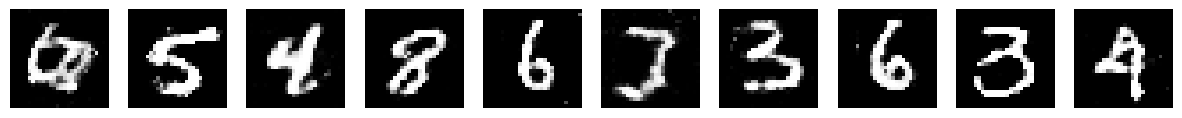

In [18]:
# Generate some images with the trained generator
n_images = 10
noise = torch.randn(n_images, 128).to(device)
fake_images = G(noise)

# Denormalize the generated images
fake_images = (fake_images * 0.5) + 0.5

# Convert the generated images to numpy arrays
fake_images = fake_images.cpu().detach().numpy()

# Plot the generated images
fig, axs = plt.subplots(1, n_images, figsize=(15, 15))
for i in range(n_images):
    axs[i].imshow(np.squeeze(fake_images[i]), cmap='gray')
    axs[i].axis('off')
plt.show()

## Висновок

Зображення цифр, сгенеровані нейронною мережею при **epochs = 100**, подібні до зображень з датасету.

Нижче наведено сгенеровані зображення при **epochs = 150**. Як показав експеримент, вони майже не відрізняються. Тобто більшої чіткості при збільшенні числа ітерацій досягти не вдалося, хоча часу на виконання програми знадобилось у півтора рази більше.

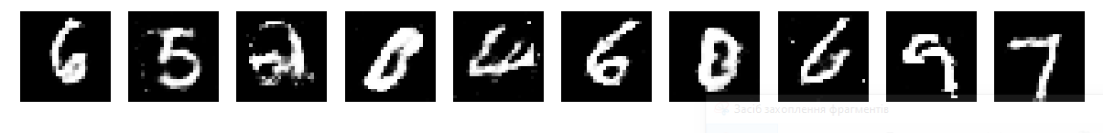